In [72]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt # plotting
import numpy as np
import pandas as pd
from sklearn import preprocessing
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# ML Classification Model:

In [24]:
ml_dataset = pd.read_parquet('./Dataset/dataset_ML.parquet', engine='pyarrow')
# ml_dataset = spark.read.parquet("./Dataset/dataset_ML.parquet")
count = ml_dataset.shape[0]
print(count)

7071817


In [25]:
ml_dataset.columns

Index(['FL_DATE', 'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'TAXI_OUT',
       'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME',
       'ARR_DELAY', 'CANCELLED', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME',
       'AIR_TIME', 'DISTANCE', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY',
       'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY'],
      dtype='object')

In [26]:
ml_dataset.CANCELLED.value_counts()

0.0    7071817
Name: CANCELLED, dtype: int64

In [28]:
sum(ml_dataset['ARR_DELAY'] >= 0)

2654069

## Create our labels:
```
    CANCELLED       -           DELAY_STATUS
          0                           0                      -> on time
          0                           1                      -> delayed
          1                           x                      -> cancelled
```
We will create a new column named `Status`:

- 0  -> on time
- 1  -> delayed
- 2  -> cancelled
    

In [29]:
status = []
for index in range(count):
    if ml_dataset['CANCELLED'][index] == 1.0:
        status.append(2)
    else:
        if ml_dataset['ARR_DELAY'][index] < 0:
            status.append(0)
        else:
            status.append(1)
            
ml_dataset['Status'] = status


In [42]:
# these won't be used in the model -> these conducts Y labels:
ml_dataset.drop(['Status','ARR_DELAY','DEP_DELAY','CANCELLED' ], axis=1, inplace=True)

In [30]:
ml_dataset.head(n=5)

,FL_DATE,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,...,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Status
0,2018-01-01,1517,1512.0,-5.0,15.0,1527.0,1712.0,10.0,1745,1722.0,...,268.0,250.0,225.0,1605.0,0.0,0.0,3.0,0.0,3.0,0
1,2018-01-01,1115,1107.0,-8.0,11.0,1118.0,1223.0,7.0,1254,1230.0,...,99.0,83.0,65.0,414.0,0.0,0.0,3.0,0.0,3.0,0
2,2018-01-01,1335,1330.0,-5.0,15.0,1345.0,1631.0,5.0,1649,1636.0,...,134.0,126.0,106.0,846.0,0.0,0.0,3.0,0.0,3.0,0
3,2018-01-01,1546,1552.0,6.0,19.0,1611.0,1748.0,6.0,1756,1754.0,...,190.0,182.0,157.0,1120.0,0.0,0.0,3.0,0.0,3.0,0
4,2018-01-01,630,650.0,20.0,13.0,703.0,926.0,10.0,922,936.0,...,112.0,106.0,83.0,723.0,0.0,0.0,3.0,0.0,3.0,1


In [31]:
ml_dataset.Status.value_counts(normalize=True)

0    0.624698
1    0.375302
Name: Status, dtype: float64

In [33]:
ml_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7071817 entries, 0 to 7071816
Data columns (total 23 columns):
 #   Column               Dtype         
---  ------               -----         
 0   FL_DATE              datetime64[ns]
 1   CRS_DEP_TIME         int64         
 2   DEP_TIME             float64       
 3   DEP_DELAY            float64       
 4   TAXI_OUT             float64       
 5   WHEELS_OFF           float64       
 6   WHEELS_ON            float64       
 7   TAXI_IN              float64       
 8   CRS_ARR_TIME         int64         
 9   ARR_TIME             float64       
 10  ARR_DELAY            float64       
 11  CANCELLED            float64       
 12  CRS_ELAPSED_TIME     float64       
 13  ACTUAL_ELAPSED_TIME  float64       
 14  AIR_TIME             float64       
 15  DISTANCE             float64       
 16  CARRIER_DELAY        float64       
 17  WEATHER_DELAY        float64       
 18  NAS_DELAY            float64       
 19  SECURITY_DELAY       

In [35]:
ml_dataset.isnull().sum()

FL_DATE                0
CRS_DEP_TIME           0
DEP_TIME               0
DEP_DELAY              0
TAXI_OUT               0
WHEELS_OFF             0
WHEELS_ON              0
TAXI_IN                0
CRS_ARR_TIME           0
ARR_TIME               0
ARR_DELAY              0
CANCELLED              0
CRS_ELAPSED_TIME       0
ACTUAL_ELAPSED_TIME    0
AIR_TIME               0
DISTANCE               0
CARRIER_DELAY          0
WEATHER_DELAY          0
NAS_DELAY              0
SECURITY_DELAY         0
LATE_AIRCRAFT_DELAY    0
Status                 0
WEEKDAY                0
dtype: int64

In [34]:
ml_dataset['FL_DATE'] = pd.to_datetime(ml_dataset['FL_DATE'])
ml_dataset['WEEKDAY'] = ml_dataset['FL_DATE'].dt.dayofweek
ml_dataset.columns

Index(['FL_DATE', 'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'TAXI_OUT',
       'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME',
       'ARR_DELAY', 'CANCELLED', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME',
       'AIR_TIME', 'DISTANCE', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY',
       'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'Status', 'WEEKDAY'],
      dtype='object')

In [36]:
ml_dataset.WEEKDAY.value_counts()

0    1065230
4    1055156
3    1047643
2    1022760
1    1010249
6    1006194
5     864585
Name: WEEKDAY, dtype: int64

In [39]:
ml_dataset.head(n=5)

,FL_DATE,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,...,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Status,WEEKDAY
0,2018-01-01,3,1512.0,-5.0,15.0,3,3,10.0,3,1722.0,...,250.0,225.0,1605.0,0.0,0.0,3.0,0.0,3.0,0,0
1,2018-01-01,2,1107.0,-8.0,11.0,2,3,7.0,3,1230.0,...,83.0,65.0,414.0,0.0,0.0,3.0,0.0,3.0,0,0
2,2018-01-01,3,1330.0,-5.0,15.0,3,3,5.0,3,1636.0,...,126.0,106.0,846.0,0.0,0.0,3.0,0.0,3.0,0,0
3,2018-01-01,3,1552.0,6.0,19.0,3,3,6.0,3,1754.0,...,182.0,157.0,1120.0,0.0,0.0,3.0,0.0,3.0,0,0
4,2018-01-01,2,650.0,20.0,13.0,2,2,10.0,2,936.0,...,106.0,83.0,723.0,0.0,0.0,3.0,0.0,3.0,1,0


In [73]:
# Normalize all features:

x = ml_dataset.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
ml_dataset = pd.DataFrame(x_scaled)

In [40]:
ml_dataset.head(n=5)

,FL_DATE,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,...,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Status,WEEKDAY
0,2018-01-01,3,1512.0,-5.0,15.0,3,3,10.0,3,1722.0,...,250.0,225.0,1605.0,0.0,0.0,3.0,0.0,3.0,0,0
1,2018-01-01,2,1107.0,-8.0,11.0,2,3,7.0,3,1230.0,...,83.0,65.0,414.0,0.0,0.0,3.0,0.0,3.0,0,0
2,2018-01-01,3,1330.0,-5.0,15.0,3,3,5.0,3,1636.0,...,126.0,106.0,846.0,0.0,0.0,3.0,0.0,3.0,0,0
3,2018-01-01,3,1552.0,6.0,19.0,3,3,6.0,3,1754.0,...,182.0,157.0,1120.0,0.0,0.0,3.0,0.0,3.0,0,0
4,2018-01-01,2,650.0,20.0,13.0,2,2,10.0,2,936.0,...,106.0,83.0,723.0,0.0,0.0,3.0,0.0,3.0,1,0


In [45]:
ml_dataset.columns

Index(['CRS_DEP_TIME', 'DEP_TIME', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON',
       'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'CANCELLED', 'CRS_ELAPSED_TIME',
       'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'CARRIER_DELAY',
       'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY'],
      dtype='object')

In [44]:
# irrelevent features: 'DEP_TIME','ARR_TIME'
ml_dataset.drop(['FL_DATE', 'WEEKDAY' ], axis=1, inplace=True)

In [75]:
X = ml_dataset
X.shape

(7071817, 18)

In [76]:
y = np.array(status)
y.shape

(7071817,)

In [77]:
# Perform the split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state = 2)

## ML Models:

#### 1. RandomForest

In [52]:
# instantiating the RandomForestClassifier
clf_rf = RandomForestClassifier(n_estimators=100, max_depth=5)
clf_rf.fit(X_train, y_train)

#check the accuracy score
clf_rf.score(X_train, y_train)

clf_rf.score(X_test, y_test)



Testing Accuracy for Random Forest Classifier: 0.8155686937733143


In [62]:
# Test set predictions
pred = clf_rf.predict(X_test)

print('Testing Accuracy for Random Forest Classifier:', accuracy_score(y_test, pred))

Testing Accuracy for Random Forest Classifier: 0.8155686937733143


In [87]:
print('Classificiation Report')
print('---------------------')
print(classification_report(y_test, pred))

Classificiation Report
---------------------
              precision    recall  f1-score   support

           0       0.77      1.00      0.87    882507
           1       1.00      0.51      0.68    531857

    accuracy                           0.82   1414364
   macro avg       0.89      0.75      0.77   1414364
weighted avg       0.86      0.82      0.80   1414364



In [88]:
# Alternative confusion matrix
plot_confusion_matrix(clf_rf, X, y , values_format='.3g')
plt.show()

ValueError: X has 18 features, but RandomForestClassifier is expecting 17 features as input.

In [ ]:
# confusion matrix and classfication report
print('\nConfusion Matrix')
print('----------------')
pd.crosstab(y_test, pred, rownames=['True'], colnames=['Predicted'], margins=True)


Confusion Matrix
----------------


Predicted,0,1,All
True,,,
0,882490,17,882507
1,260836,271021,531857
All,1143326,271038,1414364


In [ ]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(10, 20))
    plt.barh(range(n_features), model.feature_importances_, color='k', align='center')
    plt.yticks(np.arange(n_features), X_train.columns.values)
    plt.xlabel('Feature importance')
    plt.ylabel('Features')
    plt.rcParams["figure.facecolor"] = "lightblue"
    plt.grid(True)

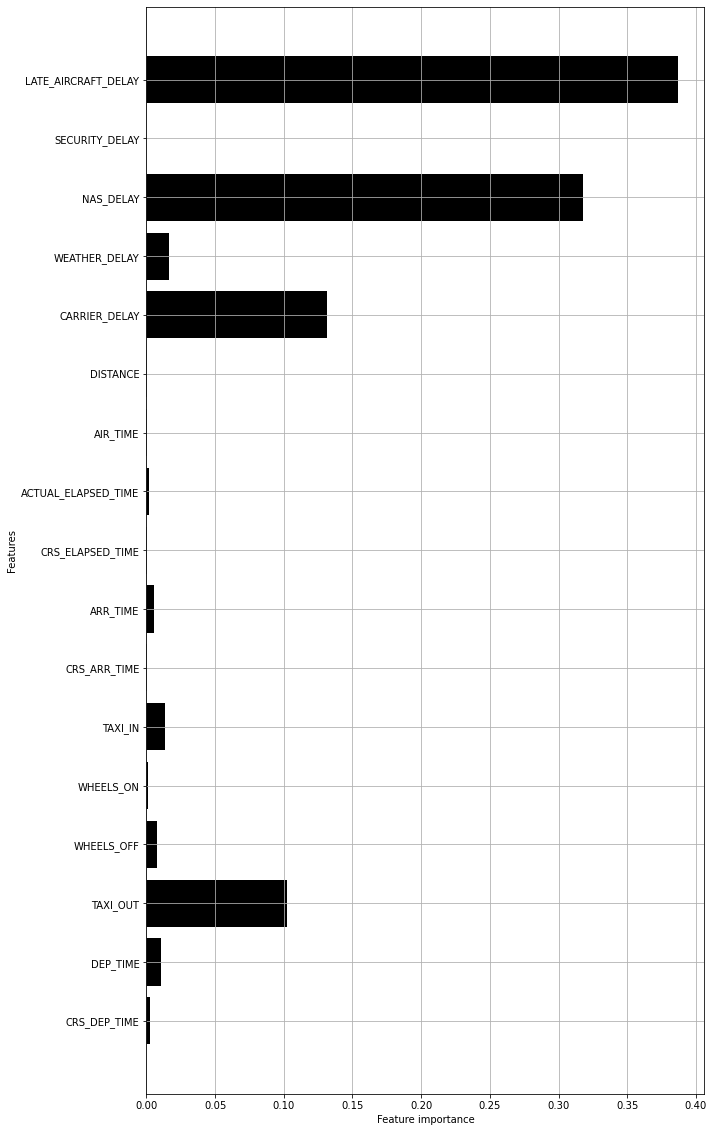

In [ ]:
#plot feature importance of Random Forest Classifier
plot_feature_importances(clf_rf)
plt.rcParams["figure.facecolor"] = "lightblue"

#### 2. Logistic Regression

In [86]:
clf_lr = LogisticRegression(solver='lbfgs',max_iter=200,random_state=1)
clf_lr.fit(X_train, y_train)
y_pred = clf_lr.predict(X_test)
print('Testing Accuracy for Logistic Regression:', accuracy_score(y_test, y_pred))

Testing Accuracy for Logistic Regression: 0.8675934907845505


In [89]:
print('Classificiation Report')
print('---------------------')
print(classification_report(y_test, y_pred))

Classificiation Report
---------------------
              precision    recall  f1-score   support

           0       0.85      0.96      0.90    882507
           1       0.91      0.72      0.80    531857

    accuracy                           0.87   1414364
   macro avg       0.88      0.84      0.85   1414364
weighted avg       0.87      0.87      0.86   1414364



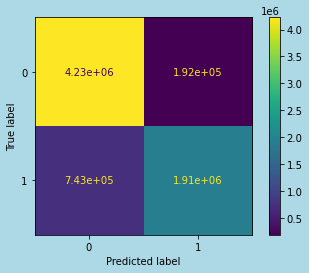

In [90]:
# Alternative confusion matrix
plot_confusion_matrix(clf_lr, X, y , values_format='.3g')
plt.show()

In [91]:
# confusion matrix and classfication report
print('\nConfusion Matrix')
print('----------------')
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)


Confusion Matrix
----------------


Predicted,0,1,All
True,,,
0,844209,38298,882507
1,148973,382884,531857
All,993182,421182,1414364


<AxesSubplot:>

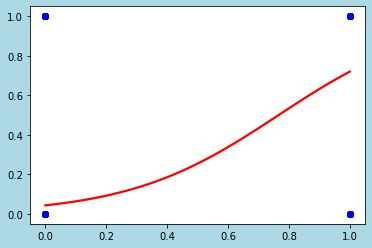

In [92]:
# plot Logistic Regression graph
sns.regplot(x= y_test , y= y_pred , logistic=True, ci=None ,scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})